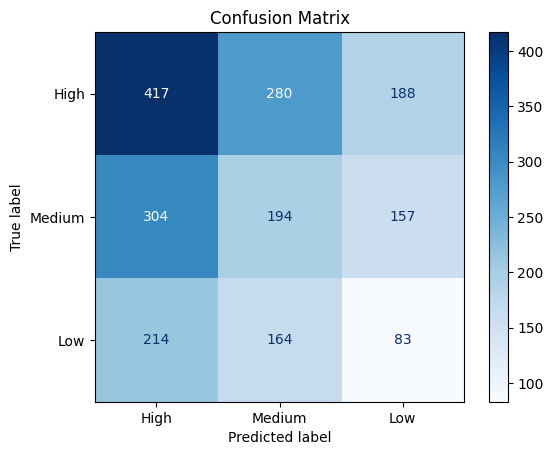


Hasil Pengukuran:
Class High:
  Precision: 0.45
  Recall: 0.47
  F1-Score: 0.46

Class Medium:
  Precision: 0.30
  Recall: 0.30
  F1-Score: 0.30

Class Low:
  Precision: 0.19
  Recall: 0.18
  F1-Score: 0.19



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def k_nearest_neighbors(X_train, y_train, x_test, k):
    distances = []

    for i in range(len(X_train)):
        distance = euclidean_distance(x_test, X_train[i])
        distances.append((X_train[i], distance, y_train[i]))

    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]

    class_votes = {}
    for neighbor in neighbors:
        label = neighbor[2]
        weight = 1 / (neighbor[1] + 1e-9) 

        if label in class_votes:
            class_votes[label] += weight
        else:
            class_votes[label] = weight

    return max(class_votes, key=class_votes.get)

def stratified_sampling(X, y, train_ratio=0.8):
    data = pd.DataFrame(X, columns=['vehicle_type', 'fuel_type', 'engine_size', 'age_of_vehicle', 'mileage'])
    data['emission_level'] = y

    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for label, group in data.groupby('emission_level'):
        train_size = int(len(group) * train_ratio)
        train_group = group.sample(train_size, random_state=42)
        test_group = group.drop(train_group.index)

        train_data = pd.concat([train_data, train_group], axis=0)
        test_data = pd.concat([test_data, test_group], axis=0)

    X_train = train_data.drop('emission_level', axis=1).values
    y_train = train_data['emission_level'].values
    X_test = test_data.drop('emission_level', axis=1).values
    y_test = test_data['emission_level'].values

    return X_train, X_test, y_train, y_test

def evaluate_multiclass(y_true, y_pred):
    unique_classes = np.unique(y_true)
    confusion_matrix = np.zeros((len(unique_classes), len(unique_classes)), dtype=int)

    class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}

    for true_label, pred_label in zip(y_true, y_pred):
        true_idx = class_to_index[true_label]
        pred_idx = class_to_index[pred_label]
        confusion_matrix[true_idx, pred_idx] += 1

    return confusion_matrix, unique_classes

# Load dataset
data = pd.read_csv('vehicle_dataset_clean.csv')

X = data[['vehicle_type', 'fuel_type', 'engine_size', 'age_of_vehicle', 'mileage']].values
y = data['emission_level'].values

# Stratified sampling
X_train, X_test, y_train, y_test = stratified_sampling(X, y)

# K value
k = 3

# Classification
predictions = [k_nearest_neighbors(X_train, y_train, test, k) for test in X_test]

# Evaluation
confusion_matrix, unique_classes = evaluate_multiclass(y_test, predictions)

label = ['High', 'Medium', 'Low']
class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
index = [class_to_index[label] for label in label]
reordered_cm = confusion_matrix[np.ix_(index, index)]
ConfusionMatrixDisplay(confusion_matrix=reordered_cm, display_labels=label).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

print("\nHasil Pengukuran:")
for cls in label:
    cls_idx = class_to_index[cls]
    TP = confusion_matrix[cls_idx, cls_idx]
    FP = np.sum(confusion_matrix[:, cls_idx]) - TP
    FN = np.sum(confusion_matrix[cls_idx, :]) - TP

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Class {cls}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1-Score: {f1_score:.2f}\n")

